# Unsupervised Feature Selection for the USPS handwritten Dataset

H. Huang, et al., "**Unsupervised Feature Selection on Data Streams**," Proc. of CIKM 2015, pp. 1031-1040, Oct. 2015.

In [1]:
import numpy as np
import numpy.linalg as ln
import pandas as pd
import sklearn.metrics as met
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from stream_fast_weight import StreamFastWeight
from gen_feat_weight import GenFeatWeight

## Load data

In [3]:
# train
with open('../../data/usps/zip.train') as f:
    X_train = []
    y_train = []
    for line in f.readlines():
        l = map(float, line.rstrip().split(' '))
        y_train.append(l[0])
        X_train.append(l[1:])
    X_train = np.array(X_train).T
    y_train = np.array(y_train).T
X_train.shape, y_train.shape

((256, 7291), (7291,))

In [4]:
# test
with open('../../data/usps/zip.test') as f:
    X_test = []
    y_test = []
    for line in f.readlines():
        l = map(float, line.rstrip().split(' '))
        y_test.append(l[0])
        X_test.append(l[1:])
    X_test = np.array(X_test).T
    y_test = np.array(y_test).T
X_test.shape, y_test.shape

((256, 2007), (2007,))

In [5]:
# merge train and test
X = np.hstack((X_train, X_test))
y = np.hstack((y_train, y_test))
X.shape, y.shape

((256, 9298), (9298,))

## Import libraries for evaluation and check the baseline

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

In [7]:
# baseline
y_pred = KMeans(n_clusters=10).fit_predict(X.T) # shape=(n_sample, n_feature)
normalized_mutual_info_score(y, y_pred)

0.62508382431293497

## Run prototype algorithm for feature weighting (Alg. 1)

*this is not sketching method; inputed matrices are stacked internaly.*

In [8]:
nt = 1000
alg1 = GenFeatWeight(X.shape[0], k=10) # initialize

In [9]:
result = []

# compute NMIs for different selected feature size
for n_features in range(25, 201, 25):
    
    start = time.clock()
    for head in xrange(0, X.shape[1], nt): # each time step
        scores = alg1.update(X[:, head:head+nt])
    end = time.clock()
    
    # selected top-n features at the final step
    selected_idx = np.argsort(scores)[::-1][:n_features]
    
    y_pred = KMeans(n_clusters=10).fit_predict(X[selected_idx,:].T)
    NMI = normalized_mutual_info_score(y, y_pred)
    result.append([n_features, NMI, end-start])

alg1_result = pd.DataFrame(result, columns=['n_features', 'NMI', 'time_sec'])
alg1_result

,n_features,NMI,time_sec
0,25,0.405653,9.173374
1,50,0.520081,24.586265
2,75,0.551276,39.595395
3,100,0.569203,54.583825
4,125,0.603090,70.261307
5,150,0.615642,85.809544
6,175,0.632129,101.707525
7,200,0.626509,116.845065


## Run fast streaming algorithm for feature weighting (Alg. 2)

In [10]:
nt = 1000
alg2 = StreamFastWeight(X.shape[0], k=10)

In [11]:
result = []

# compute NMIs for different selected feature size
for n_features in range(25, 201, 25):
    
    start = time.clock()
    for head in xrange(0, X.shape[1], nt): # each time step
        scores = alg2.update(X[:, head:head+nt])
    end = time.clock()
    
    # selected top-n features at the final step
    selected_idx = np.argsort(scores)[::-1][:n_features]
    
    y_pred = KMeans(n_clusters=10).fit_predict(X[selected_idx,:].T)
    NMI = normalized_mutual_info_score(y, y_pred)
    result.append([n_features, NMI, end-start])

alg2_result = pd.DataFrame(result, columns=['n_features', 'NMI', 'time_sec'])
alg2_result

,n_features,NMI,time_sec
0,25,0.409419,1.037534
1,50,0.528266,1.036338
2,75,0.542419,1.035008
3,100,0.585669,1.036351
4,125,0.596422,1.033633
5,150,0.615835,1.023445
6,175,0.629191,1.029916
7,200,0.622998,1.021629


## Plot the result

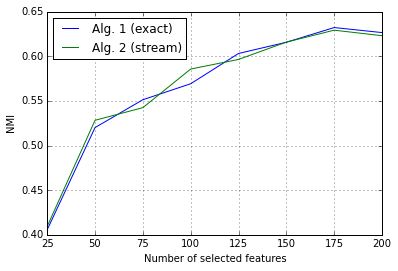

In [12]:
df = pd.DataFrame(np.vstack((np.array(alg1_result['NMI']), np.array(alg2_result['NMI']))).T, columns=['Alg. 1 (exact)', 'Alg. 2 (stream)'])
ax = df.plot()
ax.grid()
ax.set_xlabel('Number of selected features')
ax.set_ylabel('NMI')
ax.set_xticklabels(range(25, 201, 25));

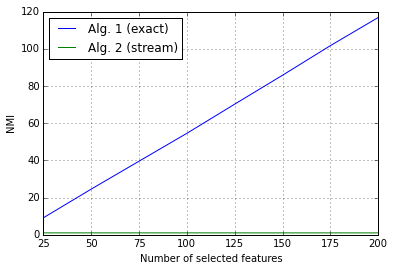

In [13]:
df = pd.DataFrame(np.vstack((np.array(alg1_result['time_sec']), np.array(alg2_result['time_sec']))).T, columns=['Alg. 1 (exact)', 'Alg. 2 (stream)'])
ax = df.plot()
ax.grid()
ax.set_xlabel('Number of selected features')
ax.set_ylabel('NMI')
ax.set_xticklabels(range(25, 201, 25));